# Udacity Nanodegree Capstone Project

The following project is a stock price prediction model. Closing price of S&P500 for 5 days in advanced have been predicted. 



# Dataset Pre-processing

## Importing Data

In [1]:
import pandas as pd
import datetime as date
import numpy as np
import scipy as sci

#Import rough data
def raw_dataset(sym,start_date,end_date):
    #Define the range of data to be considered
    start_date = '2000-01-01'
    end_date = '2017-10-30'
    dates = pd.date_range(start_date,end_date)
    raw_data = pd.DataFrame(index = dates)

    #Import the data
    raw_data = raw_data.join(pd.read_csv('{}.csv'.format(sym),index_col='Date',parse_dates=True))

    #Drop the null values
    raw_data.dropna(inplace=True)

    return raw_data

## Transforming Data

Attributes representing different technical indicators are appended to our initial raw data

In [2]:
def transform(df,window=14):
    
    # Daily return
    df['daily_returns'] = ((df['Adj Close'])/(1.0*df['Adj Close'].shift())-1)

    # 5-day Momentum 
    df['momentum'] = df['Adj Close'] - df['Adj Close'].shift(periods=5)

    # Simple Moving Average for window
    df['sma'] = df['Adj Close'].rolling(window = window).mean()
    
    # Exponential Moving Average for window
    k = 2.0/(window+1)
    df['ema'] = df['Adj Close']
    df['ema'] = (df['Adj Close'] - df['ema'].shift())*k + df['ema'].shift()
    
    # Adding upper Bollinger Band
    df['bollinger_upper'] = 2*df['Adj Close'].rolling(window = window).std() + df['sma']

    # Adding lower Bollinger Band
    df['bollinger_lower'] = df['sma'] - (2*df['Adj Close'].rolling(window = window).std())
    
    # Stochastic Oscillator for window 
    df['fast_stochastic_oscillator'] = 1.0*(df['Close']-df['Adj Close'].rolling(window=window).min())/(df['Adj Close'].rolling(window=window).max()-df['Adj Close'].rolling(window=window).min())
    df['slow_stochastic_oscillator'] =  df['fast_stochastic_oscillator'].rolling(window = window).mean()
    df['smoothed_slow_stochastic_oscillator'] = df['slow_stochastic_oscillator'].rolling(window = window).mean()

    # ROC for window of 3 days
    df['roc'] = (df['Adj Close'] * 1.0) / (df['Adj Close'].shift(periods=3)) - 1
 
    # MACD for window 
    df['macd'] = df['Adj Close'].rolling(window = window).mean() - df['Adj Close'].rolling(window=21).mean()

    # Pivot Point
    df_temp = df.shift()
    df['pivot_point'] = (df['Open'] + df_temp['High'] + df_temp['Low'] + df_temp['Adj Close'])/4.0

    # ATR for window of 14 days
    df['atr'] = df['High'] - df['Low']
    df['atr'] = (13*df['atr'].shift()+df['High'] - df['Low'])/14.0
    
    # Adding Weekly & Monthly Returns
    week_t_1 = df['Adj Close'].shift(periods=5)
    week_t_2 = df['Adj Close'].shift(periods=10)
    week_t_3 = df['Adj Close'].shift(periods=15)
    week_t_4 = df['Adj Close'].shift(periods=20)
    week_t_5 = df['Adj Close'].shift(periods=25)
    week_t_6 = df['Adj Close'].shift(periods=30)
    week_t_7 = df['Adj Close'].shift(periods=35)
    week_t_8 = df['Adj Close'].shift(periods=40)
    
    month_t_1 = df['Adj Close'].shift(periods=22)
    month_t_2 = df['Adj Close'].shift(periods=44)
    
    # Weekly returns for t-1 week
    df['weekly_return_t-1'] = df['Adj Close']/(week_t_1*1.0) - 1

    # Weekly returns for t-2 week
    df['weekly_return_t-2'] = (week_t_1*1.0)/(week_t_2*1.0) - 1

    # Weekly returns for t-3 week
    df['weekly_return_t-3'] = (week_t_2*1.0)/(week_t_3*1.0) - 1

    # Weekly returns for t-4 week
    df['weekly_return_t-4'] = (week_t_3*1.0)/(week_t_4*1.0) - 1

    # Weekly returns for t-5 week
    df['weekly_return_t-5'] = (week_t_4*1.0)/(week_t_5*1.0) - 1

    # Weekly returns for t-6 week
    df['weekly_return_t-6'] = (week_t_5*1.0)/(week_t_6*1.0) - 1

    # Weekly returns for t-7 week
    df['weekly_return_t-7'] = (week_t_6*1.0)/(week_t_7*1.0) - 1

    # Weekly returns for t-8 week
    df['weekly_return_t-8'] = (week_t_7*1.0)/(week_t_8*1.0) - 1

    
    # Monthly returns for t-1 month
    df['monthly_return_t-1'] = df['Adj Close']/(month_t_1*1.0) - 1

    # Monthly returns for t-2 month
    df['monthly_return_t-2'] = (month_t_1*1.0)/(month_t_2*1.0) - 1
    
    #On - Balance Volume Indicator for window size of window
    df['positive_signed_volume'] = df[df['daily_returns'] >= 0]['Volume']
    df['positive_signed_volume'].replace(float('nan'),0,inplace=True)
    df['negative_signed_volume'] = df[df['daily_returns'] < 0]['Volume']*(-1.0)
    df['negative_signed_volume'].replace(float('nan'),0,inplace=True)
    df['signed_volume'] = df['positive_signed_volume'] + df['negative_signed_volume']
    df['obv'] = df['signed_volume'].rolling(window=window).sum()
    df=df.drop(['positive_signed_volume','negative_signed_volume','signed_volume'],axis = 1)
    
    #RSI 
    df['shift']=df['Adj Close'].shift()
    df['gain']=df['Adj Close']-df['shift']
    df.loc[df['gain'] < 0,'gain']=0
    df['loss']=df['Adj Close']-df['shift']
    df.loc[df['loss'] >= 0,'loss']=0
    df['rs']=(df['gain'].rolling(window=14).sum())/(df['loss'].rolling(window=14).sum()*-1.0)
    df['rsi'] = 100 - (100.0/(1+df['rs']))
    df.drop(['shift','gain','loss','rs'],axis=1,inplace=True)
    
    #Fibonacci Retracement - 7 day
    high = df['Adj Close'].rolling(window=7).max()
    low = df['Adj Close'].rolling(window=7).min()
    df['uptrend_7day_fibo_0.382'] = high - ((high-low)*0.382)
    df['downtrend_7day_fibo_0.382'] = low + ((high-low)*0.382)
    df['uptrend_7day_fibo_0.5'] = high - ((high-low)*0.5)
    df['downtrend_7day_fibo_0.5'] = low + ((high-low)*0.5)
    df['uptrend_7day_fibo_0.618'] = high - ((high-low)*0.618)
    df['downtrend_7day_fibo_0.618'] = low + ((high-low)*0.618)
  
    
    #Fibonacci Retracement - 14 day
    high = df['Adj Close'].rolling(window=14).max()
    low = df['Adj Close'].rolling(window=14).min()
    df['uptrend_14day_fibo_0.382'] = high - ((high-low)*0.382)
    df['downtrend_14day_fibo_0.382'] = low + ((high-low)*0.382)
    df['uptrend_14day_fibo_0.5'] = high - ((high-low)*0.5)
    df['downtrend_14day_fibo_0.5'] = low + ((high-low)*0.5)
    df['uptrend_14day_fibo_0.618'] = high - ((high-low)*0.618)
    df['downtrend_14day_fibo_0.618'] = low + ((high-low)*0.618)
  
    
    #Fibonacci Retracement - 21 day
    high = df['Adj Close'].rolling(window=21).max()
    low = df['Adj Close'].rolling(window=21).min()
    df['uptrend_21day_fibo_0.382'] = high - ((high-low)*0.382)
    df['downtrend_21day_fibo_0.382'] = low + ((high-low)*0.382)
    df['uptrend_21day_fibo_0.5'] = high - ((high-low)*0.5)
    df['downtrend_21day_fibo_0.5'] = low + ((high-low)*0.5)
    df['uptrend_21day_fibo_0.618'] = high - ((high-low)*0.618)
    df['downtrend_21day_fibo_0.618'] = low + ((high-low)*0.618)
    
    # ADX
    df['dm'] = df['High'] - df['High'].shift() - (df['Low']-df['Low'].shift())
    df.loc[df['dm'] >= 0,'plus_dm'] = df['dm']
    df.loc[df['dm'] < 0,'plus_dm'] = 0
    df.loc[df['dm'] < 0,'minus_dm'] = df['dm']*(-1)
    df.loc[df['dm'] >= 0,'minus_dm'] = 0
    
    df['plus_dm'] = (13*df['plus_dm'].shift() + df['High'] - df['High'].shift())/14.0
    df['minus_dm'] = (13*df['minus_dm'].shift() + df['High'] - df['High'].shift())/14.0
    df['plus_di'] = (df['plus_dm']*1.0)/df['atr']
    df['minus_di'] = df['minus_dm']*1.0/df['atr']
    df['adx'] = (df['plus_di']-df['minus_di'])/(df['plus_di']+df['minus_di'])
    df['adx'] = (13*df['adx'].shift()+df['adx'])/14.0
    df.drop(['plus_dm','minus_dm','plus_di','minus_di','dm'],axis=1,inplace=True)
    
    # Dropping the Close attribute from the dataset
    df.drop(['Close'],axis=1,inplace=True)
    
    return df

## Data Scaling and Standardisation

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def scale_data(transformed_data):
    #Min Max Normalisation
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(transformed_data)
    scaled_data.dropna(inplace=True)

    
    #Standardising data
    scaled_data = (scaled_data-scaled_data.mean())/((1.0*scaled_data.std())/(scaled_data.count()**0.5))


    numericals=scaled_data.columns
    #Scaling standardised attributes
    scaled_data[numericals] = scaler.fit_transform(scaled_data[numericals])
    
    return scaled_data



## Dataset Creation Methods

First, we produce the target attribute using 'n_day_prediction' method. We then split this data into training, testing and validation set using the 'create_dataset' method. The 'reshape' method is then used to reshape the dataframe into 3-Dimensional data, suitable for our model

In [5]:

# Creating the target attribute, by shifting the specified feature backwards
def n_day_prediction(data_set,n_days,prediction_feature):
    data_set['Target'] = data_set[prediction_feature].shift(-1*n_days)
    data_set.dropna(inplace=True)
    return data_set

# Splitting the dataset, into 2 parts
def create_dataset(data_set,start_date,end_date,prediction_feature,current):
    dates = pd.date_range(start_date,end_date)
    new_set = pd.DataFrame(index=dates)
    new_set = new_set.join(data_set)
    new_set.dropna(inplace=True)
    new_result = pd.DataFrame(new_set[prediction_feature],index=new_set.index)
    new_set.drop(prediction_feature,axis=1,inplace=True)
    current_value = new_set[current]
    return new_set,new_result,current_value

# Reshaping the 2D data frame into a 3 dimensional, where the third dimension contains a fixed
# number(lookback) of previous records.
def reshape(data_set,result_set,current_value,lookback):
    if lookback == 1:
        return data_set.reshape(data_set.shape[0],1,data_set.shape[1]),result_set
    else:
        dataset=data_set[::-1]
        records=data_set.shape[0]-lookback
        columns=data_set.shape[1]
        reshaped_data=np.zeros((records,lookback,columns))
        for i in range(records):
            y_position = i + lookback
            reshaped_data[i] = data_set[i:y_position]
        reshaped_data=reshaped_data[::1]
        return reshaped_data,result_set[lookback:],current_value[lookback:]
 

# Performance Evaluation

## Defining Performance Metrics 

In [6]:
from sklearn.metrics import r2_score, mean_squared_error

def performance_metrics(y_true,y_predicted,y_current,model_name,equity):
    
    #compare=pd.DataFrame([y_true,y_predicted,y_current],columns=['True','Prediction','Current'])
    compare=pd.DataFrame(y_true,columns=['True'])
    compare['Prediction']=y_predicted
    compare['Current']=y_current
    
    len_df=compare['True'].count()
    
    scores=dict()
    
    #Calculating the R^2 Score of our predictions
    scores['r2_score']=r2_score(y_true,y_predicted)
    
    #Calculating the MSE Score of our predictions 
    scores['mean_squared_error']=mean_squared_error(y_true,y_predicted)
    
    #Optimism Ratio
    pos_count=compare[compare['Prediction']>1.015*compare['True']]['True'].count()
    scores['optimism_ratio'] = (1.0*pos_count)/(len_df)
    
    #Pessimism Ratio
    neg_count=compare[compare['Prediction']<0.985*compare['True']]['True'].count()
    scores['pessimism_ratio'] = (1.0*neg_count)/(len_df)
    
    #Return
    # We convert all the buy signals to 0 and the sell signals to 1
    compare['Action']=compare[compare['Prediction']>compare['Current']]['True']*0
    compare['Action'].replace(float('nan'),1,inplace=True)
    
    returns = 0
    
    for index,sym in compare.iterrows():
        if index == 1:
            price_day1=sym['Current']
        if index == len_df-1:
            price_finalday=sym['Current']
        
        if sym['Action'] == 0:
            returns += sym['True'] - sym['Current']
        else:
            returns += sym['Current'] - sym['True'] 
            
    scores['return_ratio']=(returns*1.0)/abs(price_finalday-price_day1)
    
    print 'The Performance Results for the {} for {} is :'.format(model_name,equity)
    print 'The Return ratio is {}'.format(scores['return_ratio'])
    print 'The R^2 score is {}'.format(scores['r2_score'])
    print 'The Mean Squared Error is {}'.format(scores['mean_squared_error'])
    print 'The Optimism ratio is {}'.format(scores['optimism_ratio'])
    print 'The Pessimism ratio is {}'.format(scores['pessimism_ratio'])
    print ''
    return scores

## Defining Graphical Visualisations 

In [7]:
def make_graph(actual,result,title,plt):
    plt.plot(actual,label='Actual Value')
    plt.plot(result,color='r',label='Predicted Value')
    plt.xlabel('Number of Records')
    plt.ylabel('Target')
    plt.legend()
    plt.title(title)

# Preparing Training, Validating and Testing Data

## Importing thr Raw Dataset and Transforming and Scaling it 

In [8]:
start_date = '2000-01-03'
end_date = '2017-10-30'

raw_data=raw_dataset('^GSPC',start_date,end_date)
transformed_data=transform(raw_data,11)

scaled_data = scale_data(transformed_data)


## Preparing the prediction target and splitting dataset into training, validation and testing dataset

In [9]:
scaled_data=n_day_prediction(scaled_data,5,'Adj Close')

training_set,training_result,training_current=create_dataset(scaled_data,'2000-03-07','2012-05-01','Target','Adj Close')
testing_set,testing_result,testing_current=create_dataset(scaled_data,'2014-06-12','2017-10-23','Target','Adj Close')
validation_set,validation_result,validation_current=create_dataset(scaled_data,'2012-05-02','2014-06-11','Target','Adj Close')


## Performing Feature Extraction on the Datasets

In [10]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=12)
ica.fit(training_set)
training_set = ica.transform(training_set)
testing_set = ica.transform(testing_set)
validation_set = ica.transform(validation_set)



## Converting the dataset into a 3-dimensional form suitable for LSTM Model

In [11]:
training_data,train_y,train_current=reshape(training_set,training_result.values,training_current.values,5)
testing_data,test_y,test_current=reshape(testing_set,testing_result.values,testing_current.values,5)
validation_data,val_y,valid_current=reshape(validation_set,validation_result.values,validation_current.values,5)

# Optimal Model

In [12]:
# Model architecture of the proposed model

from keras.layers import Dense,Dropout,BatchNormalization,LSTM,Flatten
from keras.models import Sequential


model = Sequential()
model.add(LSTM(64,activation='linear',return_sequences=True, input_shape=(training_data.shape[1],training_data.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(128,activation='linear',return_sequences=True,input_shape=(training_data.shape[1],training_data.shape[2])))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256,activation='linear',kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Dense(512,activation='linear',kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='linear',kernel_initializer='he_normal'))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 64)             19712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 128)            98816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               164096    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

## Compiling and Training the model

In [13]:
# The compilation and training of the model is executed in this block 
from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_lstm.hdf5', 
                               verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

model.fit(training_data, train_y,epochs=100, batch_size=50, validation_data=(validation_data,val_y),callbacks=[checkpointer], verbose=1)



Train on 3053 samples, validate on 525 samples
Epoch 1/100
3053/3053 [==============================] - 6s - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 3.8329e-04 - val_mean_squared_error: 3.8329e-04
Epoch 2/100
3053/3053 [==============================] - 4s - loss: 7.5406e-04 - mean_squared_error: 7.5406e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 3/100
3053/3053 [==============================] - 4s - loss: 7.4008e-04 - mean_squared_error: 7.4008e-04 - val_loss: 5.5329e-04 - val_mean_squared_error: 5.5329e-04
Epoch 4/100
3053/3053 [==============================] - 4s - loss: 6.9415e-04 - mean_squared_error: 6.9415e-04 - val_loss: 5.2562e-04 - val_mean_squared_error: 5.2562e-04
Epoch 5/100
3053/3053 [==============================] - 4s - loss: 6.3494e-04 - mean_squared_error: 6.3494e-04 - val_loss: 8.7922e-04 - val_mean_squared_error: 8.7922e-04
Epoch 6/100
3053/3053 [==============================] - 4s - loss: 6.6462e-04 - mean_squared_error: 6.6462e-

3053/3053 [==============================] - 4s - loss: 5.5489e-04 - mean_squared_error: 5.5489e-04 - val_loss: 5.8153e-04 - val_mean_squared_error: 5.8153e-04
Epoch 26/100
3053/3053 [==============================] - 4s - loss: 5.9186e-04 - mean_squared_error: 5.9186e-04 - val_loss: 2.2649e-04 - val_mean_squared_error: 2.2649e-04
Epoch 27/100
3053/3053 [==============================] - 4s - loss: 5.4604e-04 - mean_squared_error: 5.4604e-04 - val_loss: 8.6769e-04 - val_mean_squared_error: 8.6769e-04
Epoch 28/100
3053/3053 [==============================] - 4s - loss: 6.1877e-04 - mean_squared_error: 6.1877e-04 - val_loss: 3.5565e-04 - val_mean_squared_error: 3.5565e-04
Epoch 29/100
3053/3053 [==============================] - 4s - loss: 5.5045e-04 - mean_squared_error: 5.5045e-04 - val_loss: 3.1837e-04 - val_mean_squared_error: 3.1837e-04
Epoch 30/100
3053/3053 [==============================] - 4s - loss: 4.9957e-04 - mean_squared_error: 4.9957e-04 - val_loss: 2.3856e-04 - val_mean_s

3053/3053 [==============================] - 4s - loss: 5.0657e-04 - mean_squared_error: 5.0657e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 52/100
3053/3053 [==============================] - 4s - loss: 5.6217e-04 - mean_squared_error: 5.6217e-04 - val_loss: 2.9574e-04 - val_mean_squared_error: 2.9574e-04
Epoch 53/100
3053/3053 [==============================] - 4s - loss: 5.0119e-04 - mean_squared_error: 5.0119e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 54/100
3053/3053 [==============================] - 4s - loss: 5.3566e-04 - mean_squared_error: 5.3566e-04 - val_loss: 2.4197e-04 - val_mean_squared_error: 2.4197e-04
Epoch 55/100
3053/3053 [==============================] - 3s - loss: 5.3919e-04 - mean_squared_error: 5.3919e-04 - val_loss: 2.3369e-04 - val_mean_squared_error: 2.3369e-04
Epoch 56/100
3053/3053 [==============================] - 4s - loss: 4.8872e-04 - mean_squared_error: 4.8872e-04 - val_loss: 5.4845e-04 - val_mean_squared_error: 5.

3053/3053 [==============================] - 4s - loss: 4.5418e-04 - mean_squared_error: 4.5418e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 78/100
3053/3053 [==============================] - 4s - loss: 5.3231e-04 - mean_squared_error: 5.3231e-04 - val_loss: 2.3782e-04 - val_mean_squared_error: 2.3782e-04
Epoch 79/100
3053/3053 [==============================] - 4s - loss: 4.5324e-04 - mean_squared_error: 4.5324e-04 - val_loss: 4.2425e-04 - val_mean_squared_error: 4.2425e-04
Epoch 80/100
3053/3053 [==============================] - 4s - loss: 4.2483e-04 - mean_squared_error: 4.2483e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 81/100
3053/3053 [==============================] - 4s - loss: 4.9977e-04 - mean_squared_error: 4.9977e-04 - val_loss: 2.2077e-04 - val_mean_squared_error: 2.2077e-04
Epoch 82/100
3053/3053 [==============================] - 4s - loss: 4.2336e-04 - mean_squared_error: 4.2336e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013

## Producing Regression Results, Performance Analysis and Visualisation

The Performance Results for the Optimal LSTM Model for S&P 500 is :
The Return ratio is 4.30845385665
The R^2 score is 0.948616414082
The Mean Squared Error is 0.000428537034294
The Optimism ratio is 0.310426540284
The Pessimism ratio is 0.203791469194



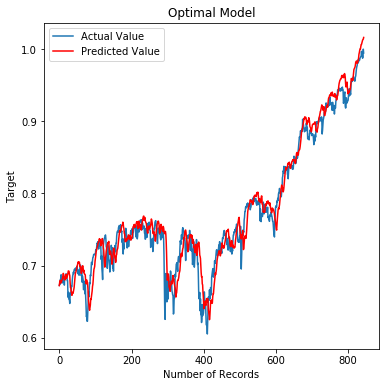

In [14]:
import matplotlib.pyplot as plt

model.load_weights('saved_models/weights.best.from_lstm.hdf5')

# Producing Regression Results
result = model.predict(testing_data)
actual=test_y
current=test_current

# Analysing the performance of the model
performance=performance_metrics(actual,result,current,'Optimal LSTM Model','S&P 500')

# Visualising the results
plt.figure(figsize=(6,6))
make_graph(actual,result,'Optimal Model',plt)
plt.show()


#  Benchmark models

## GRU Model

In [15]:
from keras.layers import Dense,Dropout,BatchNormalization,LSTM,Flatten,GRU
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

# Defining Model Architecture
model_gru = Sequential()
model_gru.add(GRU(64,activation='linear',return_sequences=True,input_shape=(training_data.shape[1],training_data.shape[2])))
model_gru.add(Dropout(0.3))
model_gru.add(GRU(128,activation='linear',return_sequences=True,input_shape=(training_data.shape[1],training_data.shape[2])))
model_gru.add(Dropout(0.3))
model_gru.add(Flatten())
model_gru.add(Dense(256,activation='linear',kernel_initializer='he_normal'))
model_gru.add(Dropout(0.3))
model_gru.add(Dense(512,activation='linear',kernel_initializer='he_normal'))
model_gru.add(Dropout(0.3))
model_gru.add(Dense(1,activation='linear',kernel_initializer='he_normal'))
model_gru.summary()

# Compiling and Training the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_gru.hdf5', 
                               verbose=1, save_best_only=True)
model_gru.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model_gru.fit(training_data, train_y,epochs=125, batch_size=50, validation_data=(validation_data,val_y),callbacks=[checkpointer], verbose=1)

#Producing Regression Results 
model_gru.load_weights('saved_models/weights.best.from_gru.hdf5')
result_gru = model_gru.predict(testing_data)
actual_gru=test_y
current_gru=test_current

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5, 64)             14784     
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 5, 128)            74112     
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               164096    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
__________

3053/3053 [==============================] - 3s - loss: 5.8711e-04 - mean_squared_error: 5.8711e-04 - val_loss: 2.5782e-04 - val_mean_squared_error: 2.5782e-04
Epoch 21/125
3053/3053 [==============================] - 3s - loss: 5.4666e-04 - mean_squared_error: 5.4666e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 22/125
3053/3053 [==============================] - 3s - loss: 6.9590e-04 - mean_squared_error: 6.9590e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 23/125
3053/3053 [==============================] - 3s - loss: 6.0679e-04 - mean_squared_error: 6.0679e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 24/125
3053/3053 [==============================] - 3s - loss: 6.0014e-04 - mean_squared_error: 6.0014e-04 - val_loss: 5.1112e-04 - val_mean_squared_error: 5.1112e-04
Epoch 25/125
3053/3053 [==============================] - 3s - loss: 5.7854e-04 - mean_squared_error: 5.7854e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 2

3053/3053 [==============================] - 3s - loss: 4.9313e-04 - mean_squared_error: 4.9313e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 47/125
3053/3053 [==============================] - 3s - loss: 5.3577e-04 - mean_squared_error: 5.3577e-04 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 48/125
3053/3053 [==============================] - 3s - loss: 5.5271e-04 - mean_squared_error: 5.5271e-04 - val_loss: 4.9942e-04 - val_mean_squared_error: 4.9942e-04
Epoch 49/125
3053/3053 [==============================] - 3s - loss: 5.6405e-04 - mean_squared_error: 5.6405e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 50/125
3053/3053 [==============================] - 3s - loss: 5.3558e-04 - mean_squared_error: 5.3558e-04 - val_loss: 3.4596e-04 - val_mean_squared_error: 3.4596e-04
Epoch 51/125
3053/3053 [==============================] - 3s - loss: 6.2320e-04 - mean_squared_error: 6.2320e-04 - val_loss: 2.8278e-04 - val_mean_squared_error: 2.8278e-04

3053/3053 [==============================] - 3s - loss: 4.3669e-04 - mean_squared_error: 4.3669e-04 - val_loss: 2.4214e-04 - val_mean_squared_error: 2.4214e-04
Epoch 73/125
3053/3053 [==============================] - 3s - loss: 5.0260e-04 - mean_squared_error: 5.0260e-04 - val_loss: 3.8150e-04 - val_mean_squared_error: 3.8150e-04
Epoch 74/125
3053/3053 [==============================] - 3s - loss: 4.2707e-04 - mean_squared_error: 4.2707e-04 - val_loss: 5.3544e-04 - val_mean_squared_error: 5.3544e-04
Epoch 75/125
3053/3053 [==============================] - 3s - loss: 4.7278e-04 - mean_squared_error: 4.7278e-04 - val_loss: 7.0738e-04 - val_mean_squared_error: 7.0738e-04
Epoch 76/125
3053/3053 [==============================] - 3s - loss: 5.2541e-04 - mean_squared_error: 5.2541e-04 - val_loss: 2.1804e-04 - val_mean_squared_error: 2.1804e-04
Epoch 77/125
3053/3053 [==============================] - 3s - loss: 4.2915e-04 - mean_squared_error: 4.2915e-04 - val_loss: 3.5214e-04 - val_mean_s

3053/3053 [==============================] - 3s - loss: 4.5568e-04 - mean_squared_error: 4.5568e-04 - val_loss: 2.3409e-04 - val_mean_squared_error: 2.3409e-04
Epoch 98/125
3053/3053 [==============================] - 3s - loss: 4.9833e-04 - mean_squared_error: 4.9833e-04 - val_loss: 2.9718e-04 - val_mean_squared_error: 2.9718e-04
Epoch 99/125
3053/3053 [==============================] - 3s - loss: 4.3107e-04 - mean_squared_error: 4.3107e-04 - val_loss: 7.1660e-04 - val_mean_squared_error: 7.1660e-04
Epoch 100/125
3053/3053 [==============================] - 3s - loss: 4.4086e-04 - mean_squared_error: 4.4086e-04 - val_loss: 7.5021e-04 - val_mean_squared_error: 7.5021e-04
Epoch 101/125
3053/3053 [==============================] - 3s - loss: 4.6648e-04 - mean_squared_error: 4.6648e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 102/125
3053/3053 [==============================] - 3s - loss: 4.4719e-04 - mean_squared_error: 4.4719e-04 - val_loss: 0.0011 - val_mean_squared_er

3053/3053 [==============================] - 3s - loss: 4.2397e-04 - mean_squared_error: 4.2397e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 124/125
3053/3053 [==============================] - 3s - loss: 4.7747e-04 - mean_squared_error: 4.7747e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 125/125
3053/3053 [==============================] - 3s - loss: 5.1195e-04 - mean_squared_error: 5.1195e-04 - val_loss: 5.3049e-04 - val_mean_squared_error: 5.3049e-04


## Multi-layer Perceptron Model

In [16]:
from keras.layers import Dense,Dropout,BatchNormalization,LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

# Defining Model Architecture
model_mlp = Sequential()
model_mlp.add(Dense(64,activation='relu',kernel_initializer='he_normal',input_shape=(12,)))
model_mlp.add(Dropout(0.3))
model_mlp.add(BatchNormalization())
model_mlp.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
model_mlp.add(Dropout(0.3))
model_mlp.add(BatchNormalization())
model_mlp.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
model_mlp.add(Dropout(0.3))
model_mlp.add(BatchNormalization())
model_mlp.add(Dense(1,activation='relu',kernel_initializer='he_normal',))
model_mlp.summary()

# Compiling and Training the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_dnn.hdf5', 
                               verbose=1, save_best_only=True)
model_mlp.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model_mlp.fit(training_set, training_result.values,epochs=1500, 
           batch_size=50, validation_data=(validation_set,validation_result.values),
           callbacks=[checkpointer], verbose=1)

#Producing Regression Results 
model_mlp.load_weights('saved_models/weights.best.from_dnn.hdf5')
result_mlp= model_mlp.predict(testing_set)
actual_mlp=testing_result.values
current_mlp=testing_current.values

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                832       
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
__________

3058/3058 [==============================] - 0s - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0380 - val_mean_squared_error: 0.0380
Epoch 21/1500
3058/3058 [==============================] - 0s - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0348 - val_mean_squared_error: 0.0348
Epoch 22/1500
3058/3058 [==============================] - 0s - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 23/1500
3058/3058 [==============================] - 0s - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 24/1500
3058/3058 [==============================] - 0s - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0252 - val_mean_squared_error: 0.0252
Epoch 25/1500
3058/3058 [==============================] - 0s - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 26/1500
3058/3058 [==============================] - 0s - lo

3058/3058 [==============================] - 0s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 48/1500
3058/3058 [==============================] - 0s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 49/1500
3058/3058 [==============================] - 0s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 50/1500
3058/3058 [==============================] - 0s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 51/1500
3058/3058 [==============================] - 0s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 52/1500
3058/3058 [==============================] - 0s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 53/1500
3058/3058 [==============================] - 0s - lo

3058/3058 [==============================] - 0s - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 75/1500
3058/3058 [==============================] - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 76/1500
3058/3058 [==============================] - 0s - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 77/1500
3058/3058 [==============================] - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 78/1500
3058/3058 [==============================] - 0s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 79/1500
3058/3058 [==============================] - 0s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 80/1500
3058/3058 [==============================] - 0s - lo

3058/3058 [==============================] - 0s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 102/1500
3058/3058 [==============================] - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 103/1500
3058/3058 [==============================] - 0s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 104/1500
3058/3058 [==============================] - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 105/1500
3058/3058 [==============================] - 0s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 106/1500
3058/3058 [==============================] - 0s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 107/1500
3058/3058 [==============================] - 0

3058/3058 [==============================] - 0s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 129/1500
3058/3058 [==============================] - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 8.6929e-04 - val_mean_squared_error: 8.6929e-04
Epoch 130/1500
3058/3058 [==============================] - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 131/1500
3058/3058 [==============================] - 0s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 132/1500
3058/3058 [==============================] - 0s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 133/1500
3058/3058 [==============================] - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 134/1500
3058/3058 [===========================

3058/3058 [==============================] - 0s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 156/1500
3058/3058 [==============================] - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 157/1500
3058/3058 [==============================] - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 4.4828e-04 - val_mean_squared_error: 4.4828e-04
Epoch 158/1500
3058/3058 [==============================] - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 159/1500
3058/3058 [==============================] - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 160/1500
3058/3058 [==============================] - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 161/1500
3058/3058 [===========================

3058/3058 [==============================] - 0s - loss: 9.4765e-04 - mean_squared_error: 9.4765e-04 - val_loss: 9.1118e-04 - val_mean_squared_error: 9.1118e-04
Epoch 183/1500
3058/3058 [==============================] - 0s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 184/1500
3058/3058 [==============================] - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 185/1500
3058/3058 [==============================] - 0s - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 8.4640e-04 - val_mean_squared_error: 8.4640e-04
Epoch 186/1500
3058/3058 [==============================] - 0s - loss: 8.4229e-04 - mean_squared_error: 8.4229e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 187/1500
3058/3058 [==============================] - 0s - loss: 9.0990e-04 - mean_squared_error: 9.0990e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 188/1500
3058/3

3058/3058 [==============================] - 0s - loss: 7.3506e-04 - mean_squared_error: 7.3506e-04 - val_loss: 4.8150e-04 - val_mean_squared_error: 4.8150e-04
Epoch 210/1500
3058/3058 [==============================] - 0s - loss: 7.2949e-04 - mean_squared_error: 7.2949e-04 - val_loss: 7.5032e-04 - val_mean_squared_error: 7.5032e-04
Epoch 211/1500
3058/3058 [==============================] - 0s - loss: 8.7715e-04 - mean_squared_error: 8.7715e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 212/1500
3058/3058 [==============================] - 0s - loss: 8.5585e-04 - mean_squared_error: 8.5585e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 213/1500
3058/3058 [==============================] - 0s - loss: 7.4930e-04 - mean_squared_error: 7.4930e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 214/1500
3058/3058 [==============================] - 0s - loss: 7.9663e-04 - mean_squared_error: 7.9663e-04 - val_loss: 3.9112e-04 - val_mean_squared_error: 

3058/3058 [==============================] - 0s - loss: 7.7684e-04 - mean_squared_error: 7.7684e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 236/1500
3058/3058 [==============================] - 0s - loss: 6.7571e-04 - mean_squared_error: 6.7571e-04 - val_loss: 6.1245e-04 - val_mean_squared_error: 6.1245e-04
Epoch 237/1500
3058/3058 [==============================] - 0s - loss: 6.9744e-04 - mean_squared_error: 6.9744e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 238/1500
3058/3058 [==============================] - 0s - loss: 8.1840e-04 - mean_squared_error: 8.1840e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 239/1500
3058/3058 [==============================] - 0s - loss: 6.8836e-04 - mean_squared_error: 6.8836e-04 - val_loss: 9.2262e-04 - val_mean_squared_error: 9.2262e-04
Epoch 240/1500
3058/3058 [==============================] - 0s - loss: 7.1131e-04 - mean_squared_error: 7.1131e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.00

3058/3058 [==============================] - 0s - loss: 6.5104e-04 - mean_squared_error: 6.5104e-04 - val_loss: 7.6348e-04 - val_mean_squared_error: 7.6348e-04
Epoch 262/1500
3058/3058 [==============================] - 0s - loss: 6.3874e-04 - mean_squared_error: 6.3874e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 263/1500
3058/3058 [==============================] - 0s - loss: 7.1522e-04 - mean_squared_error: 7.1522e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 264/1500
3058/3058 [==============================] - 0s - loss: 6.8803e-04 - mean_squared_error: 6.8803e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 265/1500
3058/3058 [==============================] - 0s - loss: 6.8042e-04 - mean_squared_error: 6.8042e-04 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 266/1500
3058/3058 [==============================] - 0s - loss: 6.2760e-04 - mean_squared_error: 6.2760e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch

3058/3058 [==============================] - 0s - loss: 6.1605e-04 - mean_squared_error: 6.1605e-04 - val_loss: 9.4259e-04 - val_mean_squared_error: 9.4259e-04
Epoch 288/1500
3058/3058 [==============================] - 0s - loss: 5.9484e-04 - mean_squared_error: 5.9484e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 289/1500
3058/3058 [==============================] - 0s - loss: 7.1092e-04 - mean_squared_error: 7.1092e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 290/1500
3058/3058 [==============================] - 0s - loss: 6.1053e-04 - mean_squared_error: 6.1053e-04 - val_loss: 6.3229e-04 - val_mean_squared_error: 6.3229e-04
Epoch 291/1500
3058/3058 [==============================] - 0s - loss: 6.6345e-04 - mean_squared_error: 6.6345e-04 - val_loss: 9.3103e-04 - val_mean_squared_error: 9.3103e-04
Epoch 292/1500
3058/3058 [==============================] - 0s - loss: 5.6988e-04 - mean_squared_error: 5.6988e-04 - val_loss: 0.0026 - val_mean_squared_err

3058/3058 [==============================] - 0s - loss: 6.4994e-04 - mean_squared_error: 6.4994e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 314/1500
3058/3058 [==============================] - 0s - loss: 6.7083e-04 - mean_squared_error: 6.7083e-04 - val_loss: 8.0624e-04 - val_mean_squared_error: 8.0624e-04
Epoch 315/1500
3058/3058 [==============================] - 0s - loss: 6.4372e-04 - mean_squared_error: 6.4372e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 316/1500
3058/3058 [==============================] - 0s - loss: 6.4020e-04 - mean_squared_error: 6.4020e-04 - val_loss: 5.4328e-04 - val_mean_squared_error: 5.4328e-04
Epoch 317/1500
3058/3058 [==============================] - 0s - loss: 6.2806e-04 - mean_squared_error: 6.2806e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 318/1500
3058/3058 [==============================] - 0s - loss: 5.9446e-04 - mean_squared_error: 5.9446e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.00

3058/3058 [==============================] - 0s - loss: 5.4346e-04 - mean_squared_error: 5.4346e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 340/1500
3058/3058 [==============================] - 0s - loss: 6.3402e-04 - mean_squared_error: 6.3402e-04 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 341/1500
3058/3058 [==============================] - 0s - loss: 5.6528e-04 - mean_squared_error: 5.6528e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 342/1500
3058/3058 [==============================] - 0s - loss: 5.9982e-04 - mean_squared_error: 5.9982e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 343/1500
3058/3058 [==============================] - 0s - loss: 5.8656e-04 - mean_squared_error: 5.8656e-04 - val_loss: 9.8406e-04 - val_mean_squared_error: 9.8406e-04
Epoch 344/1500
3058/3058 [==============================] - 0s - loss: 6.5358e-04 - mean_squared_error: 6.5358e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch

3058/3058 [==============================] - 0s - loss: 6.0223e-04 - mean_squared_error: 6.0223e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 366/1500
3058/3058 [==============================] - 0s - loss: 6.3596e-04 - mean_squared_error: 6.3596e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 367/1500
3058/3058 [==============================] - 0s - loss: 6.1292e-04 - mean_squared_error: 6.1292e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 368/1500
3058/3058 [==============================] - 0s - loss: 5.8893e-04 - mean_squared_error: 5.8893e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 369/1500
3058/3058 [==============================] - 0s - loss: 5.6621e-04 - mean_squared_error: 5.6621e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 370/1500
3058/3058 [==============================] - 0s - loss: 5.7270e-04 - mean_squared_error: 5.7270e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 371/150

3058/3058 [==============================] - 0s - loss: 5.6085e-04 - mean_squared_error: 5.6085e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 392/1500
3058/3058 [==============================] - 0s - loss: 6.1371e-04 - mean_squared_error: 6.1371e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 393/1500
3058/3058 [==============================] - 0s - loss: 5.8387e-04 - mean_squared_error: 5.8387e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 394/1500
3058/3058 [==============================] - 0s - loss: 6.0142e-04 - mean_squared_error: 6.0142e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 395/1500
3058/3058 [==============================] - 0s - loss: 5.9115e-04 - mean_squared_error: 5.9115e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 396/1500
3058/3058 [==============================] - 0s - loss: 5.5103e-04 - mean_squared_error: 5.5103e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 397/150

3058/3058 [==============================] - 0s - loss: 6.0194e-04 - mean_squared_error: 6.0194e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 419/1500
3058/3058 [==============================] - 0s - loss: 5.9981e-04 - mean_squared_error: 5.9981e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 420/1500
3058/3058 [==============================] - 0s - loss: 5.6351e-04 - mean_squared_error: 5.6351e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 421/1500
3058/3058 [==============================] - 0s - loss: 5.2150e-04 - mean_squared_error: 5.2150e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 422/1500
3058/3058 [==============================] - 0s - loss: 5.2484e-04 - mean_squared_error: 5.2484e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 423/1500
3058/3058 [==============================] - 0s - loss: 5.9193e-04 - mean_squared_error: 5.9193e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 424/150

3058/3058 [==============================] - 0s - loss: 5.8233e-04 - mean_squared_error: 5.8233e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 445/1500
3058/3058 [==============================] - 0s - loss: 5.8173e-04 - mean_squared_error: 5.8173e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 446/1500
3058/3058 [==============================] - 0s - loss: 6.0534e-04 - mean_squared_error: 6.0534e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 447/1500
3058/3058 [==============================] - 0s - loss: 6.3527e-04 - mean_squared_error: 6.3527e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 448/1500
3058/3058 [==============================] - 0s - loss: 6.0002e-04 - mean_squared_error: 6.0002e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 449/1500
3058/3058 [==============================] - 0s - loss: 5.1207e-04 - mean_squared_error: 5.1207e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 450/150

3058/3058 [==============================] - 1s - loss: 5.5650e-04 - mean_squared_error: 5.5650e-04 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 471/1500
3058/3058 [==============================] - 0s - loss: 4.9655e-04 - mean_squared_error: 4.9655e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 472/1500
3058/3058 [==============================] - 0s - loss: 4.9555e-04 - mean_squared_error: 4.9555e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 473/1500
3058/3058 [==============================] - 0s - loss: 4.9170e-04 - mean_squared_error: 4.9170e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 474/1500
3058/3058 [==============================] - 1s - loss: 5.8318e-04 - mean_squared_error: 5.8318e-04 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 475/1500
3058/3058 [==============================] - 0s - loss: 5.3340e-04 - mean_squared_error: 5.3340e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 476/150

3058/3058 [==============================] - 0s - loss: 5.2449e-04 - mean_squared_error: 5.2449e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 498/1500
3058/3058 [==============================] - 0s - loss: 5.3646e-04 - mean_squared_error: 5.3646e-04 - val_loss: 5.5957e-04 - val_mean_squared_error: 5.5957e-04
Epoch 499/1500
3058/3058 [==============================] - 0s - loss: 5.8795e-04 - mean_squared_error: 5.8795e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 500/1500
3058/3058 [==============================] - 0s - loss: 5.0484e-04 - mean_squared_error: 5.0484e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 501/1500
3058/3058 [==============================] - 0s - loss: 5.5208e-04 - mean_squared_error: 5.5208e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 502/1500
3058/3058 [==============================] - 0s - loss: 4.9099e-04 - mean_squared_error: 4.9099e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch

3058/3058 [==============================] - 0s - loss: 4.8498e-04 - mean_squared_error: 4.8498e-04 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 524/1500
3058/3058 [==============================] - 0s - loss: 4.4606e-04 - mean_squared_error: 4.4606e-04 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 525/1500
3058/3058 [==============================] - 0s - loss: 5.5371e-04 - mean_squared_error: 5.5371e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 526/1500
3058/3058 [==============================] - 0s - loss: 5.1738e-04 - mean_squared_error: 5.1738e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 527/1500
3058/3058 [==============================] - 0s - loss: 4.7826e-04 - mean_squared_error: 4.7826e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 528/1500
3058/3058 [==============================] - 0s - loss: 5.0657e-04 - mean_squared_error: 5.0657e-04 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 529/150

3058/3058 [==============================] - 0s - loss: 5.3782e-04 - mean_squared_error: 5.3782e-04 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 551/1500
3058/3058 [==============================] - 0s - loss: 5.3470e-04 - mean_squared_error: 5.3470e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 552/1500
3058/3058 [==============================] - 0s - loss: 5.1651e-04 - mean_squared_error: 5.1651e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 553/1500
3058/3058 [==============================] - 0s - loss: 5.4907e-04 - mean_squared_error: 5.4907e-04 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 554/1500
3058/3058 [==============================] - 0s - loss: 5.5527e-04 - mean_squared_error: 5.5527e-04 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 555/1500
3058/3058 [==============================] - 0s - loss: 5.4113e-04 - mean_squared_error: 5.4113e-04 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 556/150

3058/3058 [==============================] - 0s - loss: 4.8044e-04 - mean_squared_error: 4.8044e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 577/1500
3058/3058 [==============================] - 0s - loss: 4.6874e-04 - mean_squared_error: 4.6874e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 578/1500
3058/3058 [==============================] - 0s - loss: 4.9734e-04 - mean_squared_error: 4.9734e-04 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 579/1500
3058/3058 [==============================] - 0s - loss: 5.5258e-04 - mean_squared_error: 5.5258e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 580/1500
3058/3058 [==============================] - 0s - loss: 5.2680e-04 - mean_squared_error: 5.2680e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 581/1500
3058/3058 [==============================] - 0s - loss: 5.0074e-04 - mean_squared_error: 5.0074e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 582/150

3058/3058 [==============================] - 0s - loss: 5.0646e-04 - mean_squared_error: 5.0646e-04 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 604/1500
3058/3058 [==============================] - 0s - loss: 5.3401e-04 - mean_squared_error: 5.3401e-04 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 605/1500
3058/3058 [==============================] - 0s - loss: 5.2431e-04 - mean_squared_error: 5.2431e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 606/1500
3058/3058 [==============================] - 0s - loss: 4.9583e-04 - mean_squared_error: 4.9583e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 607/1500
3058/3058 [==============================] - 0s - loss: 5.5284e-04 - mean_squared_error: 5.5284e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 608/1500
3058/3058 [==============================] - 0s - loss: 5.1895e-04 - mean_squared_error: 5.1895e-04 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 609/150

3058/3058 [==============================] - 0s - loss: 4.8983e-04 - mean_squared_error: 4.8983e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 630/1500
3058/3058 [==============================] - 0s - loss: 4.7280e-04 - mean_squared_error: 4.7280e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 631/1500
3058/3058 [==============================] - 0s - loss: 4.8670e-04 - mean_squared_error: 4.8670e-04 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 632/1500
3058/3058 [==============================] - 0s - loss: 5.5859e-04 - mean_squared_error: 5.5859e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 633/1500
3058/3058 [==============================] - 0s - loss: 5.7206e-04 - mean_squared_error: 5.7206e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 634/1500
3058/3058 [==============================] - 0s - loss: 5.4343e-04 - mean_squared_error: 5.4343e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 635/150

3058/3058 [==============================] - 0s - loss: 5.8252e-04 - mean_squared_error: 5.8252e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 657/1500
3058/3058 [==============================] - 0s - loss: 5.5250e-04 - mean_squared_error: 5.5250e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 658/1500
3058/3058 [==============================] - 0s - loss: 6.4176e-04 - mean_squared_error: 6.4176e-04 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 659/1500
3058/3058 [==============================] - 0s - loss: 5.3595e-04 - mean_squared_error: 5.3595e-04 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 660/1500
3058/3058 [==============================] - 0s - loss: 5.0026e-04 - mean_squared_error: 5.0026e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 661/1500
3058/3058 [==============================] - 0s - loss: 5.6570e-04 - mean_squared_error: 5.6570e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 662/150

3058/3058 [==============================] - 0s - loss: 4.6849e-04 - mean_squared_error: 4.6849e-04 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 683/1500
3058/3058 [==============================] - 0s - loss: 4.6555e-04 - mean_squared_error: 4.6555e-04 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 684/1500
3058/3058 [==============================] - 0s - loss: 5.0495e-04 - mean_squared_error: 5.0495e-04 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 685/1500
3058/3058 [==============================] - 0s - loss: 4.6251e-04 - mean_squared_error: 4.6251e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 686/1500
3058/3058 [==============================] - 0s - loss: 4.6856e-04 - mean_squared_error: 4.6856e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 687/1500
3058/3058 [==============================] - 0s - loss: 5.2740e-04 - mean_squared_error: 5.2740e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 688/150

3058/3058 [==============================] - 0s - loss: 4.9417e-04 - mean_squared_error: 4.9417e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 709/1500
3058/3058 [==============================] - 0s - loss: 4.9129e-04 - mean_squared_error: 4.9129e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 710/1500
3058/3058 [==============================] - 0s - loss: 5.3534e-04 - mean_squared_error: 5.3534e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 711/1500
3058/3058 [==============================] - 0s - loss: 5.6265e-04 - mean_squared_error: 5.6265e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 712/1500
3058/3058 [==============================] - 0s - loss: 5.2208e-04 - mean_squared_error: 5.2208e-04 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 713/1500
3058/3058 [==============================] - 0s - loss: 5.0700e-04 - mean_squared_error: 5.0700e-04 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 714/150

3058/3058 [==============================] - 0s - loss: 5.6728e-04 - mean_squared_error: 5.6728e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 735/1500
3058/3058 [==============================] - 0s - loss: 5.2427e-04 - mean_squared_error: 5.2427e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 736/1500
3058/3058 [==============================] - 0s - loss: 4.4694e-04 - mean_squared_error: 4.4694e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 737/1500
3058/3058 [==============================] - 0s - loss: 5.2366e-04 - mean_squared_error: 5.2366e-04 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 738/1500
3058/3058 [==============================] - 0s - loss: 4.6819e-04 - mean_squared_error: 4.6819e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 739/1500
3058/3058 [==============================] - 0s - loss: 5.2744e-04 - mean_squared_error: 5.2744e-04 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 740/150

3058/3058 [==============================] - 0s - loss: 5.0110e-04 - mean_squared_error: 5.0110e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 762/1500
3058/3058 [==============================] - 0s - loss: 4.7298e-04 - mean_squared_error: 4.7298e-04 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 763/1500
3058/3058 [==============================] - 0s - loss: 5.5197e-04 - mean_squared_error: 5.5197e-04 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 764/1500
3058/3058 [==============================] - 0s - loss: 4.4621e-04 - mean_squared_error: 4.4621e-04 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 765/1500
3058/3058 [==============================] - 0s - loss: 5.2080e-04 - mean_squared_error: 5.2080e-04 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 766/1500
3058/3058 [==============================] - 0s - loss: 5.2454e-04 - mean_squared_error: 5.2454e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 767/150

3058/3058 [==============================] - 0s - loss: 4.9897e-04 - mean_squared_error: 4.9897e-04 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 788/1500
3058/3058 [==============================] - 0s - loss: 5.5037e-04 - mean_squared_error: 5.5037e-04 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 789/1500
3058/3058 [==============================] - 0s - loss: 5.1892e-04 - mean_squared_error: 5.1892e-04 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 790/1500
3058/3058 [==============================] - 0s - loss: 4.3520e-04 - mean_squared_error: 4.3520e-04 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 791/1500
3058/3058 [==============================] - 0s - loss: 5.1475e-04 - mean_squared_error: 5.1475e-04 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 792/1500
3058/3058 [==============================] - 0s - loss: 5.6441e-04 - mean_squared_error: 5.6441e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 793/150

3058/3058 [==============================] - 0s - loss: 4.9279e-04 - mean_squared_error: 4.9279e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 815/1500
3058/3058 [==============================] - 0s - loss: 5.7123e-04 - mean_squared_error: 5.7123e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 816/1500
3058/3058 [==============================] - 0s - loss: 5.3054e-04 - mean_squared_error: 5.3054e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 817/1500
3058/3058 [==============================] - 0s - loss: 6.2858e-04 - mean_squared_error: 6.2858e-04 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 818/1500
3058/3058 [==============================] - 0s - loss: 5.9312e-04 - mean_squared_error: 5.9312e-04 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 819/1500
3058/3058 [==============================] - 0s - loss: 5.3598e-04 - mean_squared_error: 5.3598e-04 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 820/150

3058/3058 [==============================] - 0s - loss: 4.8874e-04 - mean_squared_error: 4.8874e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 841/1500
3058/3058 [==============================] - 0s - loss: 6.1142e-04 - mean_squared_error: 6.1142e-04 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 842/1500
3058/3058 [==============================] - 0s - loss: 5.4280e-04 - mean_squared_error: 5.4280e-04 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 843/1500
3058/3058 [==============================] - 0s - loss: 4.8214e-04 - mean_squared_error: 4.8214e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 844/1500
3058/3058 [==============================] - 0s - loss: 4.7732e-04 - mean_squared_error: 4.7732e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 845/1500
3058/3058 [==============================] - 0s - loss: 5.2550e-04 - mean_squared_error: 5.2550e-04 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 846/150

3058/3058 [==============================] - 0s - loss: 5.3501e-04 - mean_squared_error: 5.3501e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 868/1500
3058/3058 [==============================] - 0s - loss: 5.1006e-04 - mean_squared_error: 5.1006e-04 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 869/1500
3058/3058 [==============================] - 0s - loss: 5.1668e-04 - mean_squared_error: 5.1668e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 870/1500
3058/3058 [==============================] - 0s - loss: 5.1666e-04 - mean_squared_error: 5.1666e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 871/1500
3058/3058 [==============================] - 0s - loss: 4.5637e-04 - mean_squared_error: 4.5637e-04 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 872/1500
3058/3058 [==============================] - 0s - loss: 5.5895e-04 - mean_squared_error: 5.5895e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 873/150

3058/3058 [==============================] - 0s - loss: 5.0038e-04 - mean_squared_error: 5.0038e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 894/1500
3058/3058 [==============================] - 0s - loss: 4.5446e-04 - mean_squared_error: 4.5446e-04 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 895/1500
3058/3058 [==============================] - 0s - loss: 5.0655e-04 - mean_squared_error: 5.0655e-04 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 896/1500
3058/3058 [==============================] - 0s - loss: 4.7860e-04 - mean_squared_error: 4.7860e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 897/1500
3058/3058 [==============================] - 0s - loss: 5.6411e-04 - mean_squared_error: 5.6411e-04 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 898/1500
3058/3058 [==============================] - 0s - loss: 4.8754e-04 - mean_squared_error: 4.8754e-04 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 899/150

3058/3058 [==============================] - 0s - loss: 4.7404e-04 - mean_squared_error: 4.7404e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 921/1500
3058/3058 [==============================] - 0s - loss: 5.3993e-04 - mean_squared_error: 5.3993e-04 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 922/1500
3058/3058 [==============================] - 0s - loss: 5.8400e-04 - mean_squared_error: 5.8400e-04 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 923/1500
3058/3058 [==============================] - 0s - loss: 5.5925e-04 - mean_squared_error: 5.5925e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 924/1500
3058/3058 [==============================] - 0s - loss: 5.4160e-04 - mean_squared_error: 5.4160e-04 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 925/1500
3058/3058 [==============================] - 0s - loss: 5.4995e-04 - mean_squared_error: 5.4995e-04 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 926/150

3058/3058 [==============================] - 0s - loss: 4.9636e-04 - mean_squared_error: 4.9636e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 947/1500
3058/3058 [==============================] - 0s - loss: 5.2928e-04 - mean_squared_error: 5.2928e-04 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 948/1500
3058/3058 [==============================] - 0s - loss: 5.6638e-04 - mean_squared_error: 5.6638e-04 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 949/1500
3058/3058 [==============================] - 0s - loss: 5.1359e-04 - mean_squared_error: 5.1359e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 950/1500
3058/3058 [==============================] - 0s - loss: 5.3820e-04 - mean_squared_error: 5.3820e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 951/1500
3058/3058 [==============================] - 0s - loss: 5.4825e-04 - mean_squared_error: 5.4825e-04 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 952/150

3058/3058 [==============================] - 0s - loss: 5.1825e-04 - mean_squared_error: 5.1825e-04 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 974/1500
3058/3058 [==============================] - 0s - loss: 5.2691e-04 - mean_squared_error: 5.2691e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 975/1500
3058/3058 [==============================] - 0s - loss: 5.0796e-04 - mean_squared_error: 5.0796e-04 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 976/1500
3058/3058 [==============================] - 0s - loss: 5.4532e-04 - mean_squared_error: 5.4532e-04 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 977/1500
3058/3058 [==============================] - 0s - loss: 5.3722e-04 - mean_squared_error: 5.3722e-04 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 978/1500
3058/3058 [==============================] - 0s - loss: 5.3634e-04 - mean_squared_error: 5.3634e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 979/150

3058/3058 [==============================] - 0s - loss: 5.2010e-04 - mean_squared_error: 5.2010e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 1000/1500
3058/3058 [==============================] - 0s - loss: 5.6282e-04 - mean_squared_error: 5.6282e-04 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 1001/1500
3058/3058 [==============================] - 0s - loss: 5.3197e-04 - mean_squared_error: 5.3197e-04 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 1002/1500
3058/3058 [==============================] - 0s - loss: 4.7459e-04 - mean_squared_error: 4.7459e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1003/1500
3058/3058 [==============================] - 0s - loss: 5.6048e-04 - mean_squared_error: 5.6048e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1004/1500
3058/3058 [==============================] - 0s - loss: 4.7745e-04 - mean_squared_error: 4.7745e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 10

3058/3058 [==============================] - 0s - loss: 5.0867e-04 - mean_squared_error: 5.0867e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 1026/1500
3058/3058 [==============================] - 0s - loss: 5.6852e-04 - mean_squared_error: 5.6852e-04 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 1027/1500
3058/3058 [==============================] - 0s - loss: 5.8432e-04 - mean_squared_error: 5.8432e-04 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1028/1500
3058/3058 [==============================] - 0s - loss: 4.7539e-04 - mean_squared_error: 4.7539e-04 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 1029/1500
3058/3058 [==============================] - 0s - loss: 5.3482e-04 - mean_squared_error: 5.3482e-04 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 1030/1500
3058/3058 [==============================] - 0s - loss: 4.6756e-04 - mean_squared_error: 4.6756e-04 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 10

3058/3058 [==============================] - 0s - loss: 5.3019e-04 - mean_squared_error: 5.3019e-04 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 1052/1500
3058/3058 [==============================] - 0s - loss: 4.9308e-04 - mean_squared_error: 4.9308e-04 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 1053/1500
3058/3058 [==============================] - 0s - loss: 4.6297e-04 - mean_squared_error: 4.6297e-04 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 1054/1500
3058/3058 [==============================] - 0s - loss: 5.1712e-04 - mean_squared_error: 5.1712e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 1055/1500
3058/3058 [==============================] - 0s - loss: 4.4269e-04 - mean_squared_error: 4.4269e-04 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1056/1500
3058/3058 [==============================] - 0s - loss: 5.1353e-04 - mean_squared_error: 5.1353e-04 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 10

3058/3058 [==============================] - 0s - loss: 5.6592e-04 - mean_squared_error: 5.6592e-04 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1078/1500
3058/3058 [==============================] - 0s - loss: 5.3176e-04 - mean_squared_error: 5.3176e-04 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 1079/1500
3058/3058 [==============================] - 0s - loss: 4.8445e-04 - mean_squared_error: 4.8445e-04 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 1080/1500
3058/3058 [==============================] - 0s - loss: 5.5657e-04 - mean_squared_error: 5.5657e-04 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 1081/1500
3058/3058 [==============================] - 0s - loss: 5.2140e-04 - mean_squared_error: 5.2140e-04 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1082/1500
3058/3058 [==============================] - 0s - loss: 4.4949e-04 - mean_squared_error: 4.4949e-04 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 10

3058/3058 [==============================] - 0s - loss: 5.0245e-04 - mean_squared_error: 5.0245e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1104/1500
3058/3058 [==============================] - 0s - loss: 6.3544e-04 - mean_squared_error: 6.3544e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 1105/1500
3058/3058 [==============================] - 0s - loss: 5.2424e-04 - mean_squared_error: 5.2424e-04 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 1106/1500
3058/3058 [==============================] - 0s - loss: 5.6838e-04 - mean_squared_error: 5.6838e-04 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 1107/1500
3058/3058 [==============================] - 0s - loss: 5.2282e-04 - mean_squared_error: 5.2282e-04 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 1108/1500
3058/3058 [==============================] - 0s - loss: 5.2367e-04 - mean_squared_error: 5.2367e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 11

3058/3058 [==============================] - 0s - loss: 4.7187e-04 - mean_squared_error: 4.7187e-04 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1130/1500
3058/3058 [==============================] - 0s - loss: 5.5031e-04 - mean_squared_error: 5.5031e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1131/1500
3058/3058 [==============================] - 0s - loss: 5.4407e-04 - mean_squared_error: 5.4407e-04 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1132/1500
3058/3058 [==============================] - 0s - loss: 5.0849e-04 - mean_squared_error: 5.0849e-04 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1133/1500
3058/3058 [==============================] - 0s - loss: 4.6364e-04 - mean_squared_error: 4.6364e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1134/1500
3058/3058 [==============================] - 0s - loss: 5.7350e-04 - mean_squared_error: 5.7350e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 11

3058/3058 [==============================] - 0s - loss: 6.3354e-04 - mean_squared_error: 6.3354e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1156/1500
3058/3058 [==============================] - 0s - loss: 5.0822e-04 - mean_squared_error: 5.0822e-04 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1157/1500
3058/3058 [==============================] - 0s - loss: 5.6921e-04 - mean_squared_error: 5.6921e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1158/1500
3058/3058 [==============================] - 0s - loss: 5.6194e-04 - mean_squared_error: 5.6194e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 1159/1500
3058/3058 [==============================] - 0s - loss: 4.7556e-04 - mean_squared_error: 4.7556e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1160/1500
3058/3058 [==============================] - 0s - loss: 4.6165e-04 - mean_squared_error: 4.6165e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 11

3058/3058 [==============================] - 0s - loss: 5.5332e-04 - mean_squared_error: 5.5332e-04 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 1182/1500
3058/3058 [==============================] - 0s - loss: 4.8931e-04 - mean_squared_error: 4.8931e-04 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1183/1500
3058/3058 [==============================] - 0s - loss: 5.5620e-04 - mean_squared_error: 5.5620e-04 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 1184/1500
3058/3058 [==============================] - 0s - loss: 4.9375e-04 - mean_squared_error: 4.9375e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 1185/1500
3058/3058 [==============================] - 0s - loss: 4.9417e-04 - mean_squared_error: 4.9417e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 1186/1500
3058/3058 [==============================] - 0s - loss: 4.7942e-04 - mean_squared_error: 4.7942e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 11

3058/3058 [==============================] - 0s - loss: 7.5342e-04 - mean_squared_error: 7.5342e-04 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 1208/1500
3058/3058 [==============================] - 0s - loss: 5.1525e-04 - mean_squared_error: 5.1525e-04 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1209/1500
3058/3058 [==============================] - 0s - loss: 5.0350e-04 - mean_squared_error: 5.0350e-04 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1210/1500
3058/3058 [==============================] - 0s - loss: 6.1448e-04 - mean_squared_error: 6.1448e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 1211/1500
3058/3058 [==============================] - 0s - loss: 5.0971e-04 - mean_squared_error: 5.0971e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 1212/1500
3058/3058 [==============================] - 0s - loss: 5.8845e-04 - mean_squared_error: 5.8845e-04 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 12

3058/3058 [==============================] - 0s - loss: 4.4894e-04 - mean_squared_error: 4.4894e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1234/1500
3058/3058 [==============================] - 0s - loss: 5.6646e-04 - mean_squared_error: 5.6646e-04 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 1235/1500
3058/3058 [==============================] - 0s - loss: 5.3587e-04 - mean_squared_error: 5.3587e-04 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 1236/1500
3058/3058 [==============================] - 0s - loss: 5.2646e-04 - mean_squared_error: 5.2646e-04 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 1237/1500
3058/3058 [==============================] - 0s - loss: 4.7770e-04 - mean_squared_error: 4.7770e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1238/1500
3058/3058 [==============================] - 0s - loss: 4.9470e-04 - mean_squared_error: 4.9470e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 12

3058/3058 [==============================] - 0s - loss: 5.2093e-04 - mean_squared_error: 5.2093e-04 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 1260/1500
3058/3058 [==============================] - 0s - loss: 5.1431e-04 - mean_squared_error: 5.1431e-04 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 1261/1500
3058/3058 [==============================] - 0s - loss: 5.5017e-04 - mean_squared_error: 5.5017e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1262/1500
3058/3058 [==============================] - 0s - loss: 5.3502e-04 - mean_squared_error: 5.3502e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1263/1500
3058/3058 [==============================] - 0s - loss: 4.7769e-04 - mean_squared_error: 4.7769e-04 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 1264/1500
3058/3058 [==============================] - 0s - loss: 5.1171e-04 - mean_squared_error: 5.1171e-04 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 12

3058/3058 [==============================] - 0s - loss: 5.4713e-04 - mean_squared_error: 5.4713e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1286/1500
3058/3058 [==============================] - 0s - loss: 4.8612e-04 - mean_squared_error: 4.8612e-04 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1287/1500
3058/3058 [==============================] - 0s - loss: 5.3103e-04 - mean_squared_error: 5.3103e-04 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1288/1500
3058/3058 [==============================] - 0s - loss: 4.8777e-04 - mean_squared_error: 4.8777e-04 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1289/1500
3058/3058 [==============================] - 0s - loss: 5.3720e-04 - mean_squared_error: 5.3720e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1290/1500
3058/3058 [==============================] - 0s - loss: 5.4905e-04 - mean_squared_error: 5.4905e-04 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 12

3058/3058 [==============================] - 0s - loss: 4.8714e-04 - mean_squared_error: 4.8714e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1312/1500
3058/3058 [==============================] - 0s - loss: 5.1792e-04 - mean_squared_error: 5.1792e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1313/1500
3058/3058 [==============================] - 0s - loss: 5.0467e-04 - mean_squared_error: 5.0467e-04 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 1314/1500
3058/3058 [==============================] - 0s - loss: 5.4200e-04 - mean_squared_error: 5.4200e-04 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 1315/1500
3058/3058 [==============================] - 0s - loss: 4.2905e-04 - mean_squared_error: 4.2905e-04 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1316/1500
3058/3058 [==============================] - 0s - loss: 5.4406e-04 - mean_squared_error: 5.4406e-04 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 13

3058/3058 [==============================] - 0s - loss: 4.9569e-04 - mean_squared_error: 4.9569e-04 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 1338/1500
3058/3058 [==============================] - 0s - loss: 5.5509e-04 - mean_squared_error: 5.5509e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1339/1500
3058/3058 [==============================] - 0s - loss: 4.7303e-04 - mean_squared_error: 4.7303e-04 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 1340/1500
3058/3058 [==============================] - 0s - loss: 5.5720e-04 - mean_squared_error: 5.5720e-04 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 1341/1500
3058/3058 [==============================] - 0s - loss: 4.8365e-04 - mean_squared_error: 4.8365e-04 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1342/1500
3058/3058 [==============================] - 0s - loss: 4.5914e-04 - mean_squared_error: 4.5914e-04 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 13

3058/3058 [==============================] - 0s - loss: 5.8181e-04 - mean_squared_error: 5.8181e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 1364/1500
3058/3058 [==============================] - 0s - loss: 4.3361e-04 - mean_squared_error: 4.3361e-04 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 1365/1500
3058/3058 [==============================] - 0s - loss: 5.8966e-04 - mean_squared_error: 5.8966e-04 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 1366/1500
3058/3058 [==============================] - 0s - loss: 5.3544e-04 - mean_squared_error: 5.3544e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 1367/1500
3058/3058 [==============================] - 0s - loss: 5.8371e-04 - mean_squared_error: 5.8371e-04 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 1368/1500
3058/3058 [==============================] - 0s - loss: 4.5056e-04 - mean_squared_error: 4.5056e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 13

3058/3058 [==============================] - 0s - loss: 5.2555e-04 - mean_squared_error: 5.2555e-04 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 1390/1500
3058/3058 [==============================] - 0s - loss: 4.6255e-04 - mean_squared_error: 4.6255e-04 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 1391/1500
3058/3058 [==============================] - 0s - loss: 5.4240e-04 - mean_squared_error: 5.4240e-04 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 1392/1500
3058/3058 [==============================] - 0s - loss: 5.1175e-04 - mean_squared_error: 5.1175e-04 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 1393/1500
3058/3058 [==============================] - 0s - loss: 4.8723e-04 - mean_squared_error: 4.8723e-04 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 1394/1500
3058/3058 [==============================] - 0s - loss: 5.9606e-04 - mean_squared_error: 5.9606e-04 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 13

3058/3058 [==============================] - 0s - loss: 5.2174e-04 - mean_squared_error: 5.2174e-04 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 1416/1500
3058/3058 [==============================] - 0s - loss: 5.4660e-04 - mean_squared_error: 5.4660e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1417/1500
3058/3058 [==============================] - 0s - loss: 5.0134e-04 - mean_squared_error: 5.0134e-04 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 1418/1500
3058/3058 [==============================] - 0s - loss: 4.3332e-04 - mean_squared_error: 4.3332e-04 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 1419/1500
3058/3058 [==============================] - 0s - loss: 5.6992e-04 - mean_squared_error: 5.6992e-04 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 1420/1500
3058/3058 [==============================] - 0s - loss: 5.0556e-04 - mean_squared_error: 5.0556e-04 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 14

3058/3058 [==============================] - 0s - loss: 5.4582e-04 - mean_squared_error: 5.4582e-04 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 1442/1500
3058/3058 [==============================] - 0s - loss: 5.2757e-04 - mean_squared_error: 5.2757e-04 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 1443/1500
3058/3058 [==============================] - 0s - loss: 4.4673e-04 - mean_squared_error: 4.4673e-04 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 1444/1500
3058/3058 [==============================] - 0s - loss: 5.5040e-04 - mean_squared_error: 5.5040e-04 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 1445/1500
3058/3058 [==============================] - 0s - loss: 5.1297e-04 - mean_squared_error: 5.1297e-04 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 1446/1500
3058/3058 [==============================] - 0s - loss: 5.3046e-04 - mean_squared_error: 5.3046e-04 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 14

3058/3058 [==============================] - 0s - loss: 4.9414e-04 - mean_squared_error: 4.9414e-04 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 1468/1500
3058/3058 [==============================] - 0s - loss: 5.9788e-04 - mean_squared_error: 5.9788e-04 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 1469/1500
3058/3058 [==============================] - 0s - loss: 4.5192e-04 - mean_squared_error: 4.5192e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 1470/1500
3058/3058 [==============================] - 0s - loss: 5.2380e-04 - mean_squared_error: 5.2380e-04 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 1471/1500
3058/3058 [==============================] - 0s - loss: 4.7612e-04 - mean_squared_error: 4.7612e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 1472/1500
3058/3058 [==============================] - 0s - loss: 5.4110e-04 - mean_squared_error: 5.4110e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 14

3058/3058 [==============================] - 0s - loss: 4.9377e-04 - mean_squared_error: 4.9377e-04 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 1494/1500
3058/3058 [==============================] - 0s - loss: 4.8019e-04 - mean_squared_error: 4.8019e-04 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 1495/1500
3058/3058 [==============================] - 0s - loss: 4.9401e-04 - mean_squared_error: 4.9401e-04 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 1496/1500
3058/3058 [==============================] - 0s - loss: 4.3157e-04 - mean_squared_error: 4.3157e-04 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 1497/1500
3058/3058 [==============================] - 0s - loss: 4.9793e-04 - mean_squared_error: 4.9793e-04 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 1498/1500
3058/3058 [==============================] - 0s - loss: 4.2476e-04 - mean_squared_error: 4.2476e-04 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 14

## Support Vector Machine Model

In [17]:
from sklearn.svm import SVR

# Model Definition 
model_svr = SVR(kernel='sigmoid',degree=3,gamma=0.7,epsilon=0.001,C=2)
# Model Fitting
model_svr.fit(training_set,training_result)
# Predicions using Model
result_svr=model_svr.predict(testing_set)
actual_svr=testing_result.values
current_svr=testing_current.values



/Users/akhilsethia/miniconda3/envs/ml2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Performance Comparison and Visualisations

The Performance Results for the Optimal LSTM Model for S&P 500 is :
The Return ratio is 4.30845385665
The R^2 score is 0.948616414082
The Mean Squared Error is 0.000428537034294
The Optimism ratio is 0.310426540284
The Pessimism ratio is 0.203791469194

The Performance Results for the GRU Model for S&P 500 is :
The Return ratio is 5.72224266136
The R^2 score is 0.938698110062
The Mean Squared Error is 0.000511255289824
The Optimism ratio is 0.447867298578
The Pessimism ratio is 0.120853080569

The Performance Results for the Support Vector Machine Model for S&P 500 is :
The Return ratio is -1.85813038125
The R^2 score is 0.93495169979
The Mean Squared Error is 0.000543045840887
The Optimism ratio is 0.0800942285041
The Pessimism ratio is 0.631330977621

The Performance Results for the Multi-Layer Perceptron Model for S&P 500 is :
The Return ratio is 2.4787194139
The R^2 score is 0.874004358621
The Mean Squared Error is 0.00105185544894
The Optimism ratio is 0.689045936396
The Pessimism

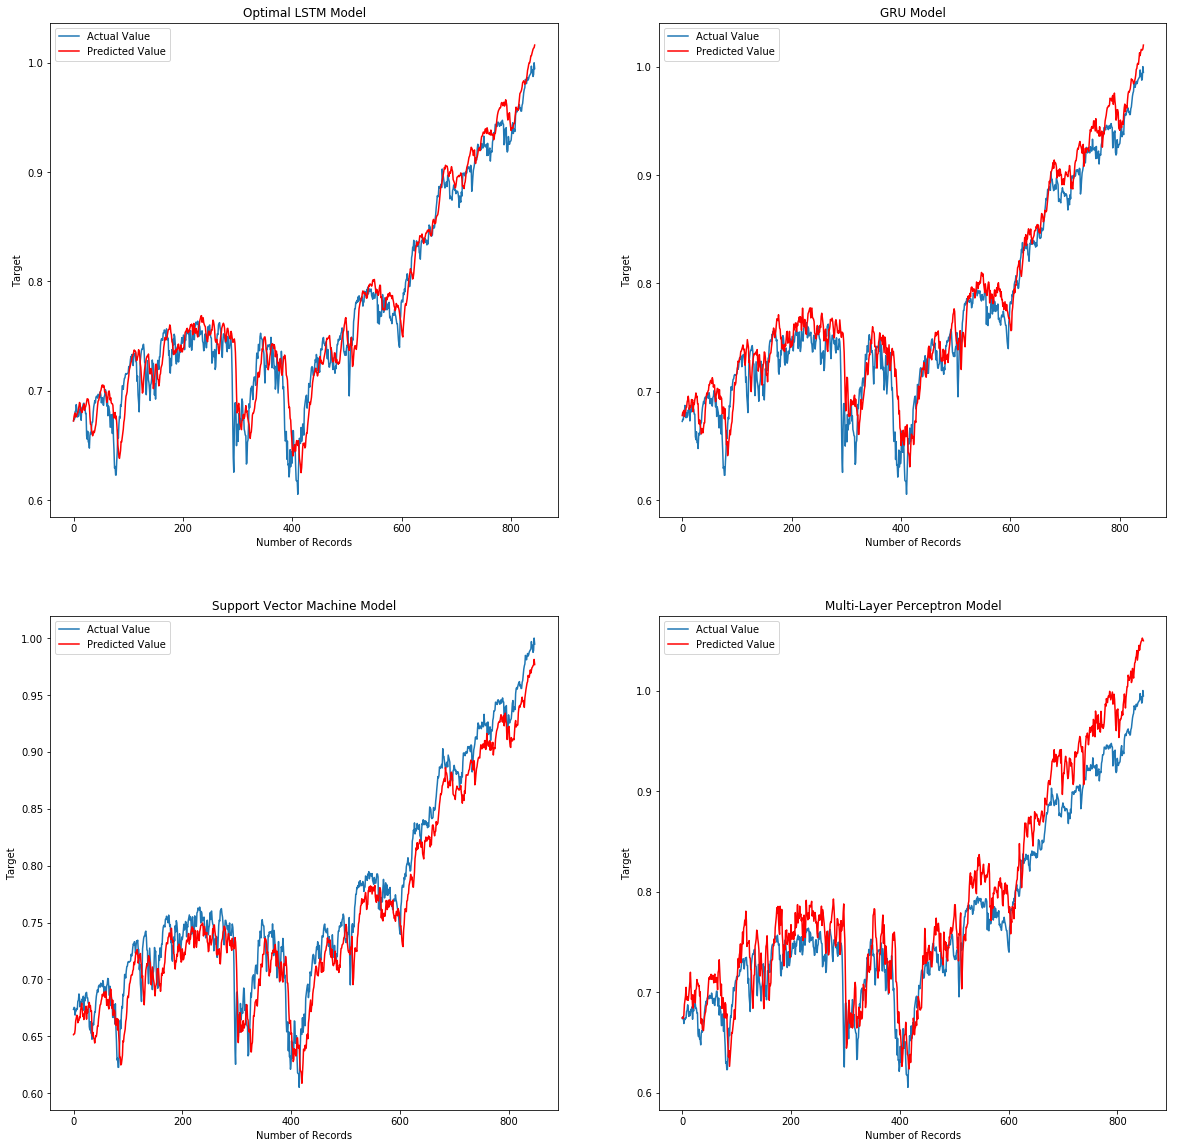

In [21]:
import matplotlib.pyplot as plt

actual_data=[actual,actual_gru,actual_svr,actual_mlp]
result_data=[result,result_gru,result_svr,result_mlp]
current_data=[current,current_gru,current_svr,current_mlp]
titles=['Optimal LSTM Model','GRU Model','Support Vector Machine Model','Multi-Layer Perceptron Model']

# Computing and Printing Performance Statistics
for i in range(4):
    performance_metrics(actual_data[i],result_data[i],current_data[i],titles[i],'S&P 500')

# Visualising the predictions made by each model    
plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(2,2,i+1)
    make_graph(actual_data[i],result_data[i],titles[i],plt)
plt.show()


# Free Form Visualisation

The Performance Results for the Optimal LSTM Model for Alphabet Inc. is :
The Return ratio is 1.29728108267
The R^2 score is 0.76962692061
The Mean Squared Error is 0.0153461937972
The Optimism ratio is 0.507936507937
The Pessimism ratio is 0.460317460317

The Performance Results for the Optimal LSTM Model for Amazon.com is :
The Return ratio is 7.49052643066
The R^2 score is 0.574845676839
The Mean Squared Error is 0.0181112551275
The Optimism ratio is 0.719576719577
The Pessimism ratio is 0.206349206349

The Performance Results for the Optimal LSTM Model for Apple Inc. is :
The Return ratio is 1.10276728416
The R^2 score is 0.698532100552
The Mean Squared Error is 0.0104885263117
The Optimism ratio is 0.470899470899
The Pessimism ratio is 0.444444444444

The Performance Results for the Optimal LSTM Model for Intel Inc. is :
The Return ratio is -3.66107187982
The R^2 score is 0.622686565956
The Mean Squared Error is 0.0102923262995
The Optimism ratio is 0.507936507937
The Pessimism ra

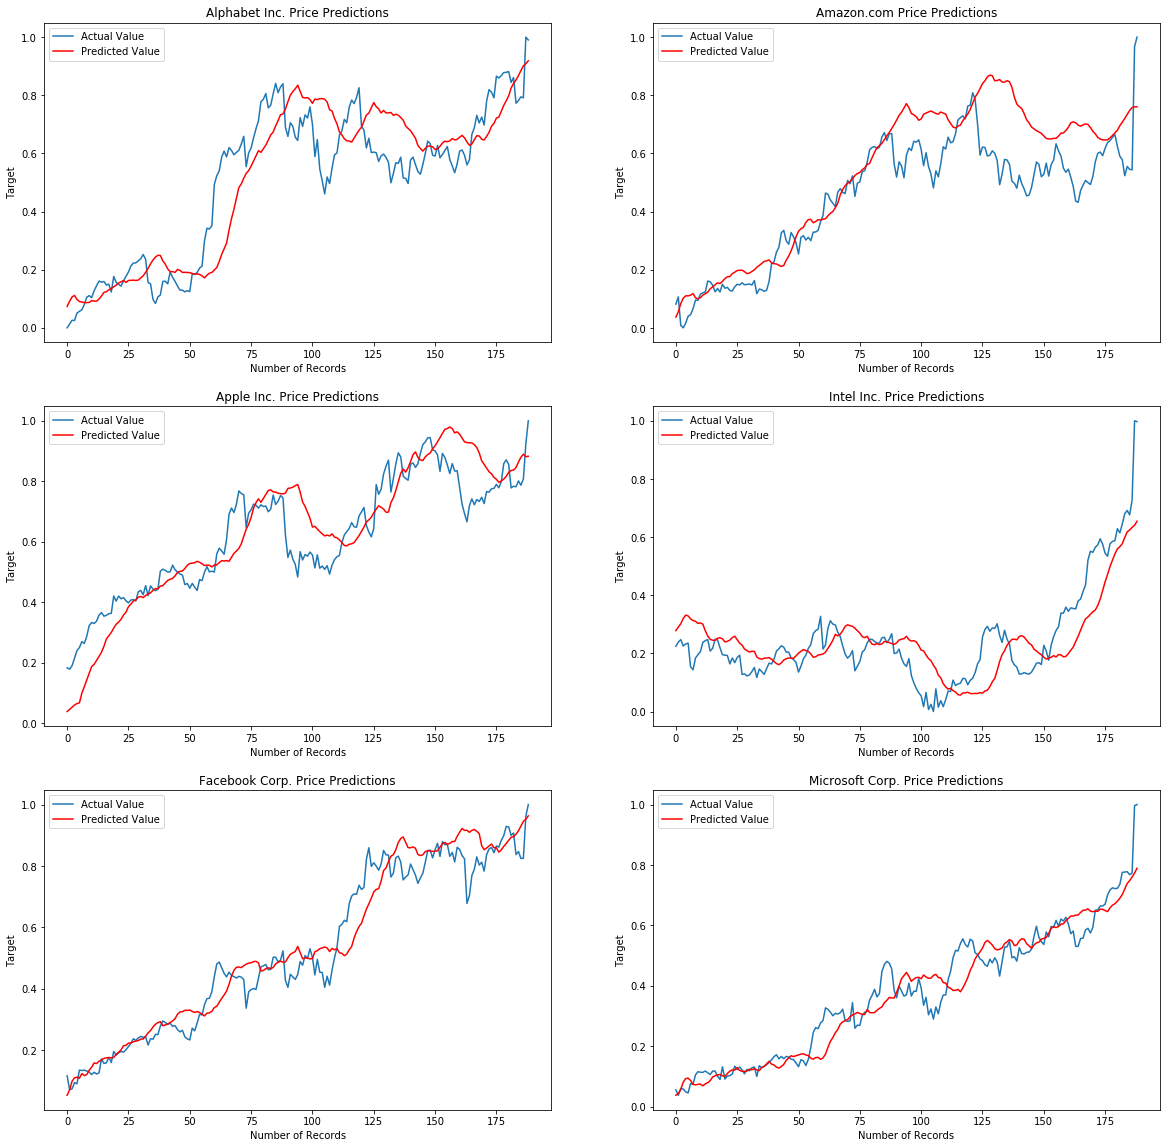

In [20]:
start_date = '2016-11-11'
end_date = '2017-11-10'
stocks=['GOOG','AMZN','AAPL','INTC','FB','MSFT']
google=None
amazon=None
apple=None
intel=None
facebook=None
microsoft=None
actual_data=[google,amazon,apple,intel,facebook,microsoft]
result_data=[google,amazon,apple,intel,facebook,microsoft]
current_data=[google,amazon,apple,intel,facebook,microsoft]

titles=['Alphabet Inc.','Amazon.com','Apple Inc.','Intel Inc.','Facebook Corp.','Microsoft Corp.']

# Preparing the required datasets
for i in range(6):
    #Importing transforming raw data
    raw_data_freeform = raw_dataset(stocks[i],start_date,end_date)
    transformed_data_freeform = transform(raw_data_freeform,11)
    scaled_data_freeform = scale_data(transformed_data_freeform) 
    
    #Producing a target attribute
    scaled_data_freeform = n_day_prediction(scaled_data_freeform,5,'Adj Close')

    #Performing feature selection and reshaping data so it can be used by model
    testing_set,testing_result,testing_current=create_dataset(scaled_data_freeform,'2017-01-18','2017-11-10','Target','Adj Close')
    testing_set = ica.transform(testing_set)
    testing_data,test_y,testing_current=reshape(testing_set,testing_result.values,testing_current.values,5)

# Running regression tests
    result_data[i]= model.predict(testing_data)
    actual_data[i]=test_y
    current_data[i]=testing_current

# Computing Regression Metrics and printing them    
    performance_metrics(actual_data[i],result_data[i],current_data[i],'Optimal LSTM Model',titles[i])


# Visualising Results

plt.figure(figsize=(20,20))
for i in range(6):
    plt.subplot(3,2,i+1)
    make_graph(actual_data[i],result_data[i],titles[i]+' Price Predictions',plt)
plt.show()
    